In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 8)

# Описание данных

Дота 2 - многопользовательская онлайн игра, где игроки объединяются в команды по 5 человек и играют на карте с башнями и троном для каждой команды (Силы Света или Силы Тьмы), сторона выпадает рандомно. Игроки должны осаждать вражеские башни, убивая вражеских героев и оборонять свои постройки.

После смерти герои снова появляются на карте спустя 30-120 секунд в зависимости от их уровня. Игра заканчивается, когда одна из команд ломает вражеский трон (предварительно сломав все башни и другие постройки на карте, защищающие трон)

In [3]:
matches = pd.read_csv('matches_df_train.csv')
players = pd.read_csv('player_df.csv')
heroes = pd.read_csv('Constants.Heroes.csv')

matches.head()

,match_id,date,region,game_mode,duration,radiant_win
0,1606558457,2024-01-01,3,1,50,True
1,1533104773,2024-01-01,3,1,86,True
2,1494396881,2024-01-01,3,1,211,True
3,1457581060,2024-01-01,3,1,270,True
4,1590242915,2024-01-01,3,21,318,True


In [4]:
players.head()

,player_slot,account_id,hero_id,kills,deaths,assists,gold,last_hits,denies,gold_per_min,xp_per_min,hero_damage,tower_damage,match_id
0,130,10111871,5,3.0,8.0,15.0,2971.0,55.0,3.0,291.0,390.0,7431.0,146.0,1411590681
1,130,43341844,3,3.0,9.0,3.0,1245.0,25.0,3.0,238.0,346.0,4187.0,34.0,1388958799
2,130,72157343,53,9.0,6.0,20.0,4544.0,226.0,1.0,583.0,704.0,9406.0,2375.0,1587246664
3,1,4294967295,17,21.0,3.0,15.0,2945.0,209.0,12.0,577.0,641.0,30957.0,1801.0,1490278157
4,2,54350942,19,9.0,8.0,8.0,413.0,227.0,9.0,471.0,584.0,18215.0,627.0,1526223166


In [5]:
heroes.head()

,Unnamed: 0,id,name,primary_attr,attack_type,roles,img,icon,base_health,base_health_regen,...,attack_rate,base_attack_time,attack_point,move_speed,turn_rate,cm_enabled,legs,day_vision,night_vision,localized_name
0,0,1,npc_dota_hero_antimage,agi,Melee,"['Carry', 'Escape', 'Nuker']",/apps/dota2/images/dota_react/heroes/antimage....,/apps/dota2/images/dota_react/heroes/icons/ant...,120,1.00,...,1.4,100,0.30,310,NaN,True,2,1800,800,Anti-Mage
1,1,2,npc_dota_hero_axe,str,Melee,"['Initiator', 'Durable', 'Disabler', 'Carry']",/apps/dota2/images/dota_react/heroes/axe.png?,/apps/dota2/images/dota_react/heroes/icons/axe...,120,2.50,...,1.7,100,0.40,315,NaN,True,2,1800,800,Axe
2,2,3,npc_dota_hero_bane,all,Ranged,"['Support', 'Disabler', 'Nuker', 'Durable']",/apps/dota2/images/dota_react/heroes/bane.png?,/apps/dota2/images/dota_react/heroes/icons/ban...,120,0.25,...,1.7,100,0.30,305,NaN,True,4,1800,1200,Bane
3,3,4,npc_dota_hero_bloodseeker,agi,Melee,"['Carry', 'Disabler', 'Nuker', 'Initiator']",/apps/dota2/images/dota_react/heroes/bloodseek...,/apps/dota2/images/dota_react/heroes/icons/blo...,120,0.25,...,1.7,100,0.43,285,NaN,True,2,1800,800,Bloodseeker
4,4,5,npc_dota_hero_crystal_maiden,int,Ranged,"['Support', 'Disabler', 'Nuker']",/apps/dota2/images/dota_react/heroes/crystal_m...,/apps/dota2/images/dota_react/heroes/icons/cry...,120,0.25,...,1.7,100,0.45,280,NaN,True,2,1800,800,Crystal Maiden


Для начала удалим ненужные столбцы из таблиц:

В таблице matches нам никак не поможет код региона и game mode
В таблице players нужно убрать last_hits, denies, gold_per_min, xp_per_min, hero_damage, tower_damage
В таблице heroes нужно оставить только столбцы: pimary_attr, attack_type, roles, localizzed_name

In [6]:
matches = matches[[
    'match_id',
    'date', 
    'duration', 
    'radiant_win'
]]

players = players[[
    'match_id',
    'account_id',
    'player_slot',      # нужен для определения команды (0-4 Radiant, 128-132 Dire)
    'hero_id',
    'kills',
    'deaths',
    'assists',
    'gold'
]]

heroes = heroes[[
    'id', 
    'localized_name',
    'primary_attr',
    'attack_type',
    'roles'
]].rename(columns={'id': 'hero_id'})

In [7]:
players = players.merge(heroes, on='hero_id', how='left')
players.head()

,match_id,account_id,player_slot,hero_id,kills,deaths,assists,gold,localized_name,primary_attr,attack_type,roles
0,1411590681,10111871,130,5,3.0,8.0,15.0,2971.0,Crystal Maiden,int,Ranged,"['Support', 'Disabler', 'Nuker']"
1,1388958799,43341844,130,3,3.0,9.0,3.0,1245.0,Bane,all,Ranged,"['Support', 'Disabler', 'Nuker', 'Durable']"
2,1587246664,72157343,130,53,9.0,6.0,20.0,4544.0,Nature's Prophet,int,Ranged,"['Carry', 'Pusher', 'Escape', 'Nuker']"
3,1490278157,4294967295,1,17,21.0,3.0,15.0,2945.0,Storm Spirit,int,Ranged,"['Carry', 'Escape', 'Nuker', 'Initiator', 'Dis..."
4,1526223166,54350942,2,19,9.0,8.0,8.0,413.0,Tiny,str,Melee,"['Carry', 'Nuker', 'Pusher', 'Initiator', 'Dur..."


In [8]:
players.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7650825 entries, 0 to 7650824
Data columns (total 12 columns):
 #   Column          Dtype  
---  ------          -----  
 0   match_id        int64  
 1   account_id      int64  
 2   player_slot     int64  
 3   hero_id         int64  
 4   kills           float64
 5   deaths          float64
 6   assists         float64
 7   gold            float64
 8   localized_name  object 
 9   primary_attr    object 
 10  attack_type     object 
 11  roles           object 
dtypes: float64(4), int64(4), object(4)
memory usage: 700.5+ MB


In [9]:
matches.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 706880 entries, 0 to 706879
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   match_id     706880 non-null  int64 
 1   date         706880 non-null  object
 2   duration     706880 non-null  int64 
 3   radiant_win  706880 non-null  bool  
dtypes: bool(1), int64(2), object(1)
memory usage: 16.9+ MB


In [10]:
df = players.merge(matches, on='match_id', how='left')
df.head()

,match_id,account_id,player_slot,hero_id,kills,deaths,assists,gold,localized_name,primary_attr,attack_type,roles,date,duration,radiant_win
0,1411590681,10111871,130,5,3.0,8.0,15.0,2971.0,Crystal Maiden,int,Ranged,"['Support', 'Disabler', 'Nuker']",2024-08-09,2418.0,False
1,1388958799,43341844,130,3,3.0,9.0,3.0,1245.0,Bane,all,Ranged,"['Support', 'Disabler', 'Nuker', 'Durable']",2024-04-24,1971.0,True
2,1587246664,72157343,130,53,9.0,6.0,20.0,4544.0,Nature's Prophet,int,Ranged,"['Carry', 'Pusher', 'Escape', 'Nuker']",2024-06-23,2581.0,False
3,1490278157,4294967295,1,17,21.0,3.0,15.0,2945.0,Storm Spirit,int,Ranged,"['Carry', 'Escape', 'Nuker', 'Initiator', 'Dis...",2024-11-29,3038.0,True
4,1526223166,54350942,2,19,9.0,8.0,8.0,413.0,Tiny,str,Melee,"['Carry', 'Nuker', 'Pusher', 'Initiator', 'Dur...",2024-11-15,2802.0,False


In [11]:
df['team'] = (df['player_slot'] >= 128).map({False: 'radiant', True: 'dire'})

Данные представлены в нескольких таблицах формата .csv

**matches (данные о матчах)**

- match_id (идентификатор матча)
- date
- region
- gamemode
- duration
- radiant_win

**players (данные о героях)**

- match_id (идентификатор матча)
- player_slot (слот игрока)
- assists (помощь в убийстве другим игрокам)
- deaths (летальные исходы игрока)
- denies (кол-во денаев, полученных игроком во время матча)
- gold_per_min (золото в минуту)
- hero_id идентификатор героя
- item_0, item_1, item_2, item_3, item_4, item_5 (оружие героя)
- kills (кол-во убийств, совершенных игроком)
- xp_per_min опыт в минуту
- isRadiant (команда: True-свет; Folse-тьма)
- win результат матча(1-победа, 0-поражение)



**Исследовательский вопрос**

Возможно ли предсказать исход матча до его начала на исторических данных с помощью модели машинного обучения

Очевидно, что по статистике матча: перевес голды, опыта, продолжительности можно предсказать, какая команда сильнее и какая команда победит, но возможно ли сделать это до начала матча, когда нам известны только игроки, герои и исторические данные.

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7650925 entries, 0 to 7650924
Data columns (total 16 columns):
 #   Column          Dtype  
---  ------          -----  
 0   match_id        int64  
 1   account_id      int64  
 2   player_slot     int64  
 3   hero_id         int64  
 4   kills           float64
 5   deaths          float64
 6   assists         float64
 7   gold            float64
 8   localized_name  object 
 9   primary_attr    object 
 10  attack_type     object 
 11  roles           object 
 12  date            object 
 13  duration        float64
 14  radiant_win     object 
 15  team            object 
dtypes: float64(5), int64(4), object(7)
memory usage: 934.0+ MB


# Исследовательский анализ данных

По задумке в датасете каждая строка должна показывать конкретного игрока в конкретном матче. Посмотрим число уникальных игроков и число уникальных матчей.

In [13]:
print(f"Всего игроков: {df['account_id'].nunique():,}")
print(f"Всего уникальных матчей: {df['match_id'].nunique():,}")
print(f"Игроков на матч: {len(df) / df['match_id'].nunique():.1f} (должно быть ~10)\n")

Всего игроков: 974,931
Всего уникальных матчей: 767,822
Игроков на матч: 10.0 (должно быть ~10)



## Анализ выбросов

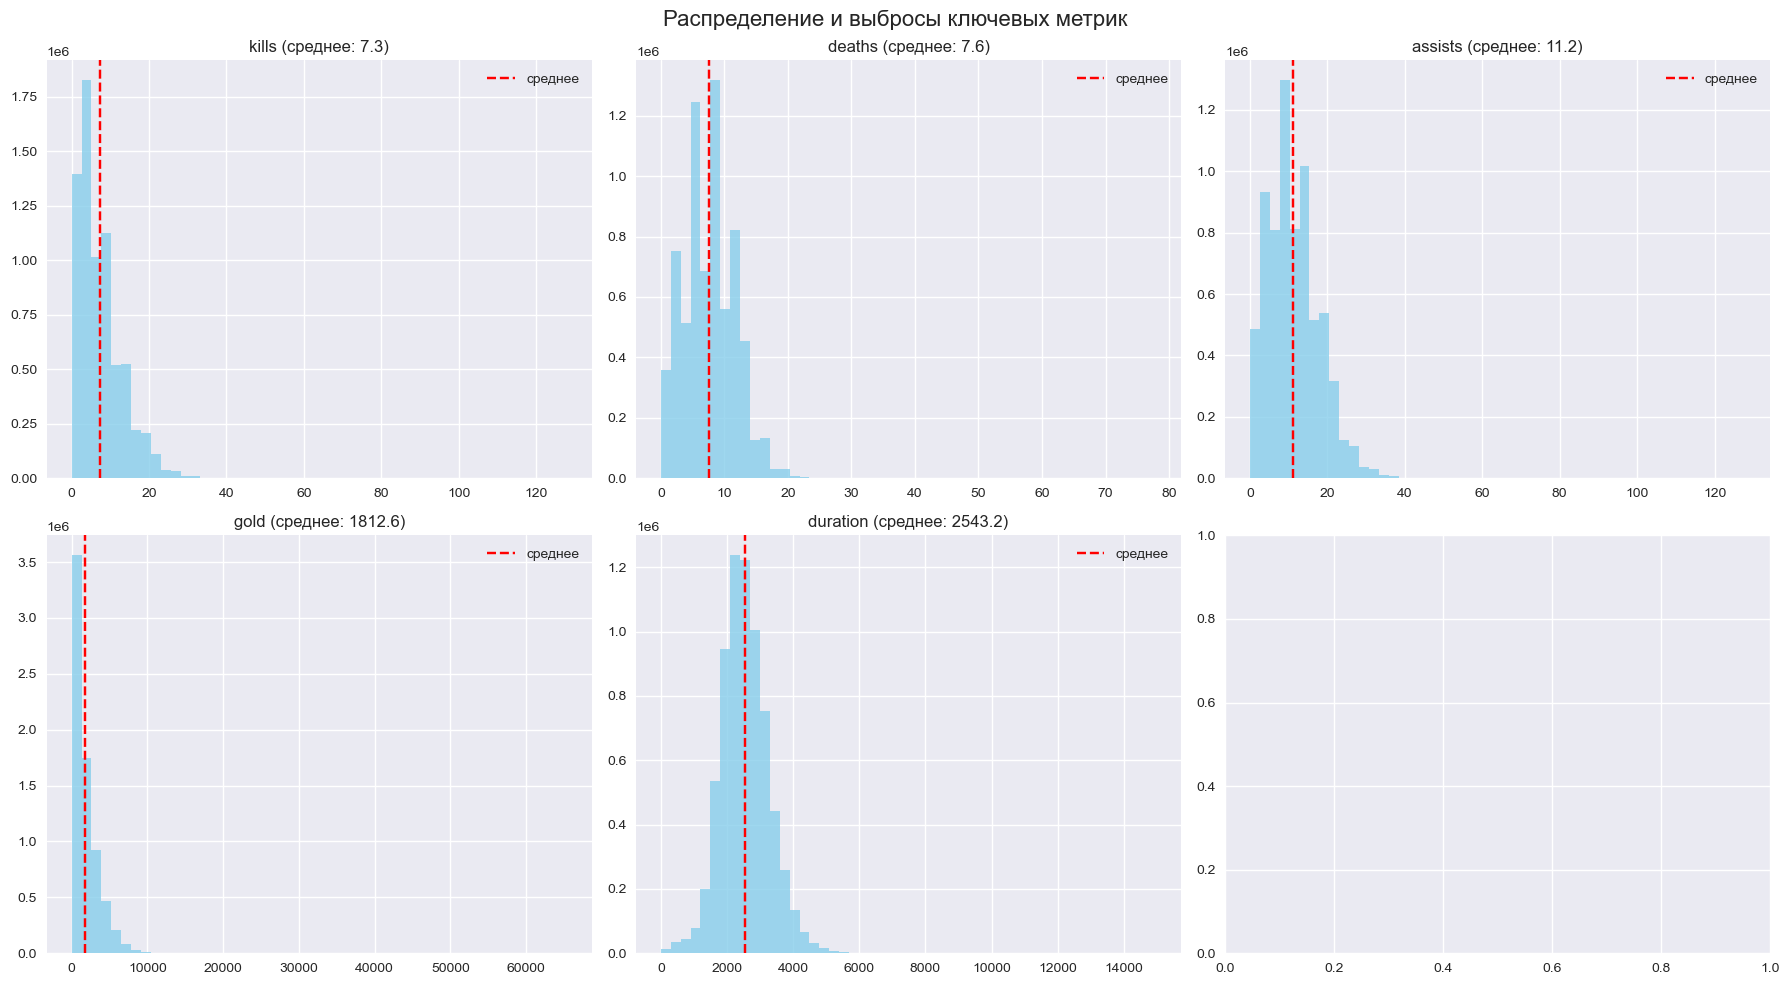

In [14]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Распределение и выбросы ключевых метрик', fontsize=16)

cols = ['kills', 'deaths', 'assists', 'gold', 'duration']
for i, col in enumerate(cols):
    ax = axes[i//3, i%3]
    df[col].hist(bins=50, ax=ax, color='skyblue', alpha=0.8)
    ax.set_title(f'{col} (среднее: {df[col].mean():.1f})')
    ax.axvline(df[col].mean(), color='red', linestyle='--', label='среднее')
    ax.legend()

plt.tight_layout()
plt.show()

## Анализ пропусков

In [15]:
df.isna().sum()

match_id               0
account_id             0
player_slot            0
hero_id                0
kills             607504
deaths            607504
assists           607504
gold              607504
localized_name      3615
primary_attr        3615
attack_type         3615
roles               3615
date              607494
duration          607494
radiant_win       607494
team                   0
dtype: int64

In [16]:
print(f"Всего строк: {len(df):,}")
ghost_players = df[df['duration'].isna()]
print(f"Строк-призраков (нет данных о матче): {len(ghost_players):,}")
ghost_matches = df[df['kills'].isna() & df['deaths'].isna() & df['assists'].isna()]
print(f"Матчей без игроков: {len(ghost_matches):,}")
real_rows = df[df['duration'].notna() & df['kills'].notna()]
print(f"Реальных строк (игрок + матч): {len(real_rows):,}")

Всего строк: 7,650,925
Строк-призраков (нет данных о матче): 607,494
Матчей без игроков: 607,504
Реальных строк (игрок + матч): 7,043,411


In [17]:
df = df.dropna(subset=['match_id', 'duration', 'radiant_win', 'kills', 'deaths', 'assists', 'localized_name'])

print(f"После очистки: {len(df):,} строк")
print(df.isna().sum()[df.isna().sum() > 0])

После очистки: 7,040,065 строк
Series([], dtype: int64)


## Вопросы анализа

In [18]:
df['team'] = np.where(df['player_slot'] < 128, 'radiant', 'dire')
df['player_win'] = np.where(
    (df['team'] == 'radiant') & (df['radiant_win'] == True) |
    (df['team'] == 'dire') & (df['radiant_win'] == False),
    True, False
)

### Какая команда побеждает чаще?

In [19]:
winrate_rad = df.groupby('match_id')['radiant_win'].first().mean()
print(f"Radiant (Свет) побеждает в {winrate_rad:.2%} матчей")
print(f"Dire (Тьма) побеждает в {(1-winrate_rad):.2%}")

Radiant (Свет) побеждает в 51.25% матчей
Dire (Тьма) побеждает в 48.75%


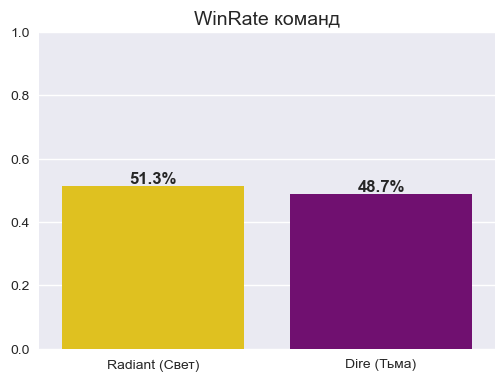

In [20]:
fig = plt.figure(figsize=(20, 14))
gs = fig.add_gridspec(3, 3)
ax1 = fig.add_subplot(gs[0, 0])
sns.barplot(x=['Radiant (Свет)', 'Dire (Тьма)'], y=[winrate_rad, 1-winrate_rad], palette=['gold', 'purple'], ax=ax1)
ax1.set_title('WinRate команд', fontsize=14)
ax1.set_ylim(0, 1)
for i, v in enumerate([winrate_rad, 1-winrate_rad]):
    ax1.text(i, v + 0.01, f'{v:.1%}', ha='center', fontweight='bold', fontsize=12)

### Самые популярные и непопулярные герои

In [21]:
top_hero = df['localized_name'].value_counts().head(1)
print(f"\n Самый популярный герой: {top_hero.index[0]} — выбран {top_hero.iloc[0]:,} раз")


 Самый популярный герой: Pudge — выбран 161,673 раз


Text(0.5, 1.0, 'Топ-10 самых популярных героев')

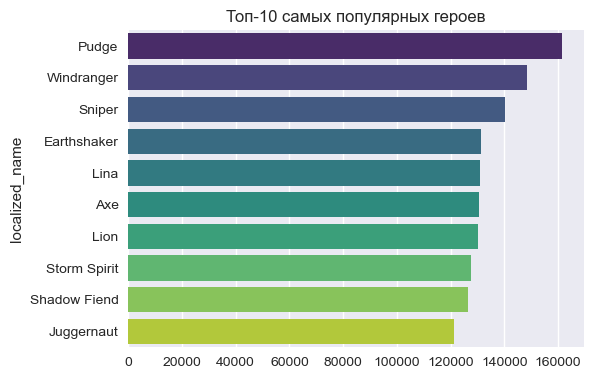

In [22]:
fig = plt.figure(figsize=(20, 14))
gs = fig.add_gridspec(3, 3)
ax2 = fig.add_subplot(gs[0, 1])
top10 = df['localized_name'].value_counts().head(10)
sns.barplot(y=top10.index, x=top10.values, palette='viridis', ax=ax2)
ax2.set_title('Топ-10 самых популярных героев')

In [23]:
atop_hero = df['localized_name'].value_counts().tail(1)
print(f"\n Самый непопулярный герой: {atop_hero.index[0]} — выбран {atop_hero.iloc[0]:,} раз")


 Самый непопулярный герой: Chen — выбран 16,467 раз


Text(0.5, 1.0, 'Топ-10 самых непопулярных героев')

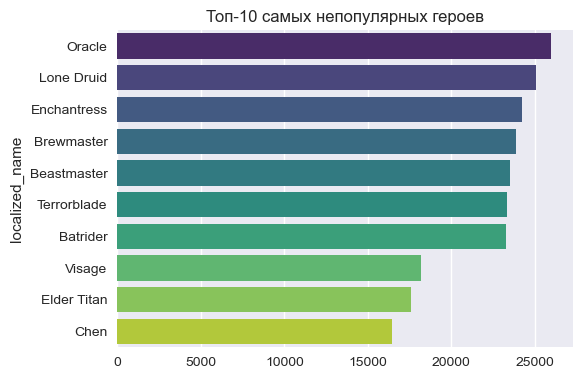

In [24]:
fig = plt.figure(figsize=(20, 14))
gs = fig.add_gridspec(3, 3)
ax2 = fig.add_subplot(gs[0, 1])
atop10 = df['localized_name'].value_counts().tail(10)
sns.barplot(y=atop10.index, x=atop10.values, palette='viridis', ax=ax2)
ax2.set_title('Топ-10 самых непопулярных героев')

### Герои с наибольшей и наименьшей долей побед

In [25]:
hero_winrate = df.groupby('localized_name')['player_win'].mean().sort_values(ascending=False)
print(f"Герой с наибольшим винрейтом: {hero_winrate.index[0]} — {hero_winrate.iloc[0]:.2%} побед")

Герой с наибольшим винрейтом: Undying — 58.51% побед


Text(0.5, 1.0, 'Топ-10 героев по винрейту')

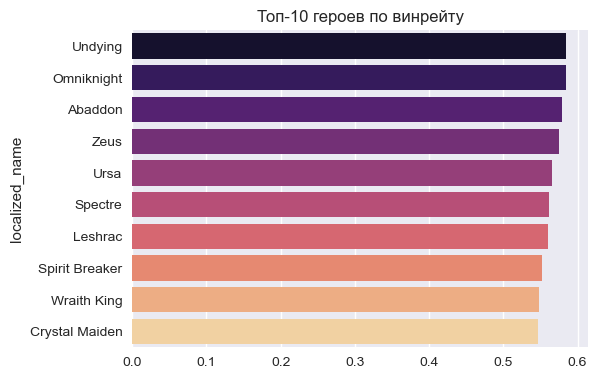

In [26]:
fig = plt.figure(figsize=(20, 14))
gs = fig.add_gridspec(3, 3)
ax3 = fig.add_subplot(gs[0, 2])
top_wr = hero_winrate.head(10)
sns.barplot(y=top_wr.index, x=top_wr.values, palette='magma', ax=ax3)
ax3.set_title('Топ-10 героев по винрейту')

In [27]:
hero_loserate = df.groupby('localized_name')['player_win'].mean().sort_values(ascending=True)
print(f"Герой с наименьшим винрейтом: {hero_winrate.index[0]} — {hero_winrate.iloc[0]:.2%} побед")

Герой с наименьшим винрейтом: Undying — 58.51% побед


Text(0.5, 1.0, 'АнтиТоп-10 героев по винрейту')

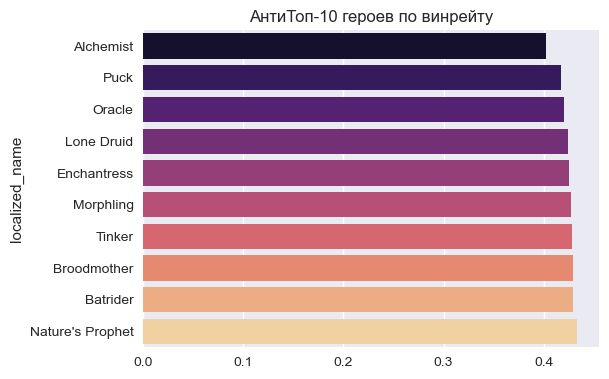

In [28]:
fig = plt.figure(figsize=(20, 14))
gs = fig.add_gridspec(3, 3)
ax3 = fig.add_subplot(gs[0, 2])
atop_wr = hero_loserate.head(10)
sns.barplot(y=atop_wr.index, x=atop_wr.values, palette='magma', ax=ax3)
ax3.set_title('АнтиТоп-10 героев по винрейту')

Можем заметить, что герой влияет на победу в игре

### Распределение длительностей матчей

In [29]:
avg_duration = df['duration'].mean() / 60
print(f"\n7. Средняя длительность матча: {avg_duration:.2f} минут")


7. Средняя длительность матча: 42.39 минут


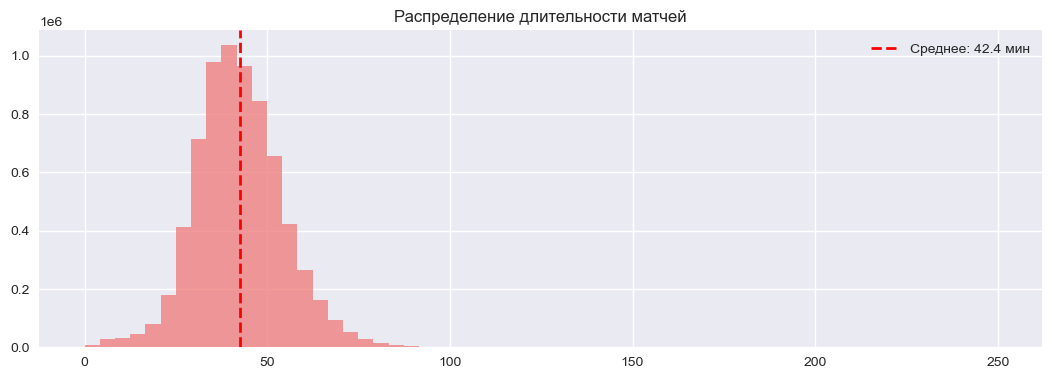

In [30]:
fig = plt.figure(figsize=(20, 14))
gs = fig.add_gridspec(3, 3)
ax7 = fig.add_subplot(gs[2, :2])
df['duration_min'] = df['duration'] / 60
df['duration_min'].hist(bins=60, ax=ax7, color='lightcoral', alpha=0.8)
ax7.axvline(avg_duration, color='red', linestyle='--', linewidth=2, label=f'Среднее: {avg_duration:.1f} мин')
ax7.set_title('Распределение длительности матчей')
ax7.legend()

## Создание новых признаков

In [31]:
df.head()

,match_id,account_id,player_slot,hero_id,kills,deaths,assists,gold,localized_name,primary_attr,attack_type,roles,date,duration,radiant_win,team,player_win,duration_min
0,1411590681,10111871,130,5,3.0,8.0,15.0,2971.0,Crystal Maiden,int,Ranged,"['Support', 'Disabler', 'Nuker']",2024-08-09,2418.0,False,dire,True,40.300000
1,1388958799,43341844,130,3,3.0,9.0,3.0,1245.0,Bane,all,Ranged,"['Support', 'Disabler', 'Nuker', 'Durable']",2024-04-24,1971.0,True,dire,False,32.850000
2,1587246664,72157343,130,53,9.0,6.0,20.0,4544.0,Nature's Prophet,int,Ranged,"['Carry', 'Pusher', 'Escape', 'Nuker']",2024-06-23,2581.0,False,dire,True,43.016667
3,1490278157,4294967295,1,17,21.0,3.0,15.0,2945.0,Storm Spirit,int,Ranged,"['Carry', 'Escape', 'Nuker', 'Initiator', 'Dis...",2024-11-29,3038.0,True,radiant,True,50.633333
4,1526223166,54350942,2,19,9.0,8.0,8.0,413.0,Tiny,str,Melee,"['Carry', 'Nuker', 'Pusher', 'Initiator', 'Dur...",2024-11-15,2802.0,False,radiant,False,46.700000


Для эффективного предсказания исхода матча мы хотим узнать винрейт каждого героя за год - может быть, какие-то герои практически гарантируют победу или поражение

Мы также хотим узнать винрейт каждого игрока на каждом герое за год. То есть, например, если игрок регулярно хорошо играет на конкретном герое: он скорее всего хорошо сыграет и в этой игре тоже

Кроме того, сущетсвуют связки: возможно, какие-то герои неэффективны по одному, но эффективны в паре. Посмотрим винрейт для всех пар героев

Также стоит подумать о контр-пиках: может быть, если одна команда пикнула героя А, а другая героя Б, герой А имеет винрейт около 20% именно против героя Б

### Связки героев

In [32]:
def get_team_heroes(group):
    heroes = group[group['team'] == 'radiant']['localized_name'].tolist()
    if len(heroes) != 5:
        heroes += group[group['team'] == 'dire']['localized_name'].tolist()
    return sorted(heroes)
matches = df.groupby('match_id').apply(lambda g: pd.Series({
    'radiant_heroes': sorted(g[g['team']=='radiant']['localized_name'].tolist()),
    'dire_heroes':    sorted(g[g['team']=='dire']['localized_name'].tolist()),
    'radiant_win':    g['radiant_win'].iloc[0]
})).reset_index()
synergy = []
for _, row in matches.iterrows():
    for hero1, hero2 in combinations(row['radiant_heroes'], 2):
        synergy.append({'hero1': hero1, 'hero2': hero2, 'team': 'radiant', 'win': row['radiant_win']})
    for hero1, hero2 in combinations(row['dire_heroes'], 2):
        synergy.append({'hero1': hero1, 'hero2': hero2, 'team': 'dire', 'win': row['radiant_win'] == False})

synergy_df = pd.DataFrame(synergy)
pair_stats = synergy_df.groupby(['hero1','hero2']).agg(
    games=('win', 'count'),
    wins=('win', 'sum')
).reset_index()
pair_stats['winrate'] = pair_stats['wins'] / pair_stats['games']
pair_stats = pair_stats[pair_stats['games'] >= 30]  # фильтр шума

best_synergy = pair_stats.sort_values('winrate', ascending=False).head(10)
worst_synergy = pair_stats.sort_values('winrate').head(10)

print("Лучшие пары (синергия):")
display(best_synergy[['hero1','hero2','games','winrate']])
print("Худшие пары (антисинергия):")
display(worst_synergy[['hero1','hero2','games','winrate']])

Лучшие пары (синергия):


,hero1,hero2,games,winrate
3788,Leshrac,Undying,5614,0.672248
3752,Leshrac,Omniknight,2638,0.664139
4888,Omniknight,Zeus,4813,0.659672
5715,Spirit Breaker,Undying,3904,0.656762
5965,Undying,Zeus,6871,0.652161
1858,Crystal Maiden,Omniknight,2794,0.651754
5954,Undying,Ursa,2956,0.650880
108,Abaddon,Zeus,3211,0.649642
5701,Spectre,Zeus,4941,0.648249
5976,Ursa,Zeus,4099,0.648207


Худшие пары (антисинергия):


,hero1,hero2,games,winrate
4893,Oracle,Puck,671,0.302534
154,Alchemist,Lone Druid,793,0.310214
688,Batrider,Morphling,521,0.310940
174,Alchemist,Puck,1217,0.312243
113,Alchemist,Batrider,646,0.312693
3318,Io,Lone Druid,436,0.316514
670,Batrider,Io,426,0.316901
1281,Broodmother,Lone Druid,476,0.317227
137,Alchemist,Enchantress,833,0.319328
3325,Io,Morphling,678,0.320059


In [33]:
counter = []
for _, row in matches.iterrows():
    for h_rad in row['radiant_heroes']:
        for h_dire in row['dire_heroes']:
            if h_rad != h_dire:
                counter.append({
                    'hero_a': h_rad,
                    'hero_b': h_dire,
                    'a_won': row['radiant_win']
                })

counter_df = pd.DataFrame(counter)
counter_stats = counter_df.groupby(['hero_a','hero_b']).agg(
    games=('a_won', 'count'),
    a_wins=('a_won', 'sum')
).reset_index()
counter_stats['winrate_a'] = counter_stats['a_wins'] / counter_stats['games']

counter_stats = counter_stats[counter_stats['games'] >= 15]

best_counter = counter_stats.sort_values('winrate_a', ascending=False).head(15)
worst_counter = counter_stats.sort_values('winrate_a').head(15)

print("ЛУЧШИЕ КОНТР-ПИКИ (герой A бьёт героя B):")
display(best_counter[['hero_a','hero_b','games','winrate_a']])

ЛУЧШИЕ КОНТР-ПИКИ (герой A бьёт героя B):


,hero_a,hero_b,games,winrate_a
29,Abaddon,Enchantress,467,0.721627
6650,Omniknight,Alchemist,947,0.718057
10627,Undying,Morphling,893,0.709966
6715,Omniknight,Puck,873,0.709049
10574,Undying,Alchemist,1360,0.703676
6655,Omniknight,Batrider,461,0.696312
11,Abaddon,Broodmother,597,0.688442
4639,Leshrac,Oracle,586,0.687713
9114,Spectre,Puck,796,0.687186
10603,Undying,Enchantress,661,0.686838


In [34]:
player_hero_stats = df.groupby(['account_id', 'localized_name']).agg(
    games=('match_id', 'nunique'),
    wins=('player_win', 'sum')
).reset_index()
player_hero_stats['player_hero_winrate'] = player_hero_stats['wins'] / player_hero_stats['games']
player_hero_stats = player_hero_stats[player_hero_stats['games'] >= 30]  # минимум 30 игр

top_players = player_hero_stats.sort_values('player_hero_winrate', ascending=False).head(15)

print("\nТОП-15 игроков по винрейту на своём герое (мин. 10 игр):")
display(top_players[['account_id','localized_name','games','player_hero_winrate']])


ТОП-15 игроков по винрейту на своём герое (мин. 10 игр):


,account_id,localized_name,games,player_hero_winrate
3299531,230610150,Earthshaker,33,0.969697
701458,51823648,Phantom Lancer,30,0.933333
965758,67906875,Zeus,34,0.911765
554661,42805962,Phantom Assassin,33,0.909091
2885129,165580342,Sniper,32,0.906250
3300268,230827073,Shadow Fiend,44,0.886364
883617,63900909,Legion Commander,40,0.875000
2610257,138860325,Riki,31,0.870968
720906,53128056,Abaddon,59,0.864407
478662,38584608,Bloodseeker,34,0.852941


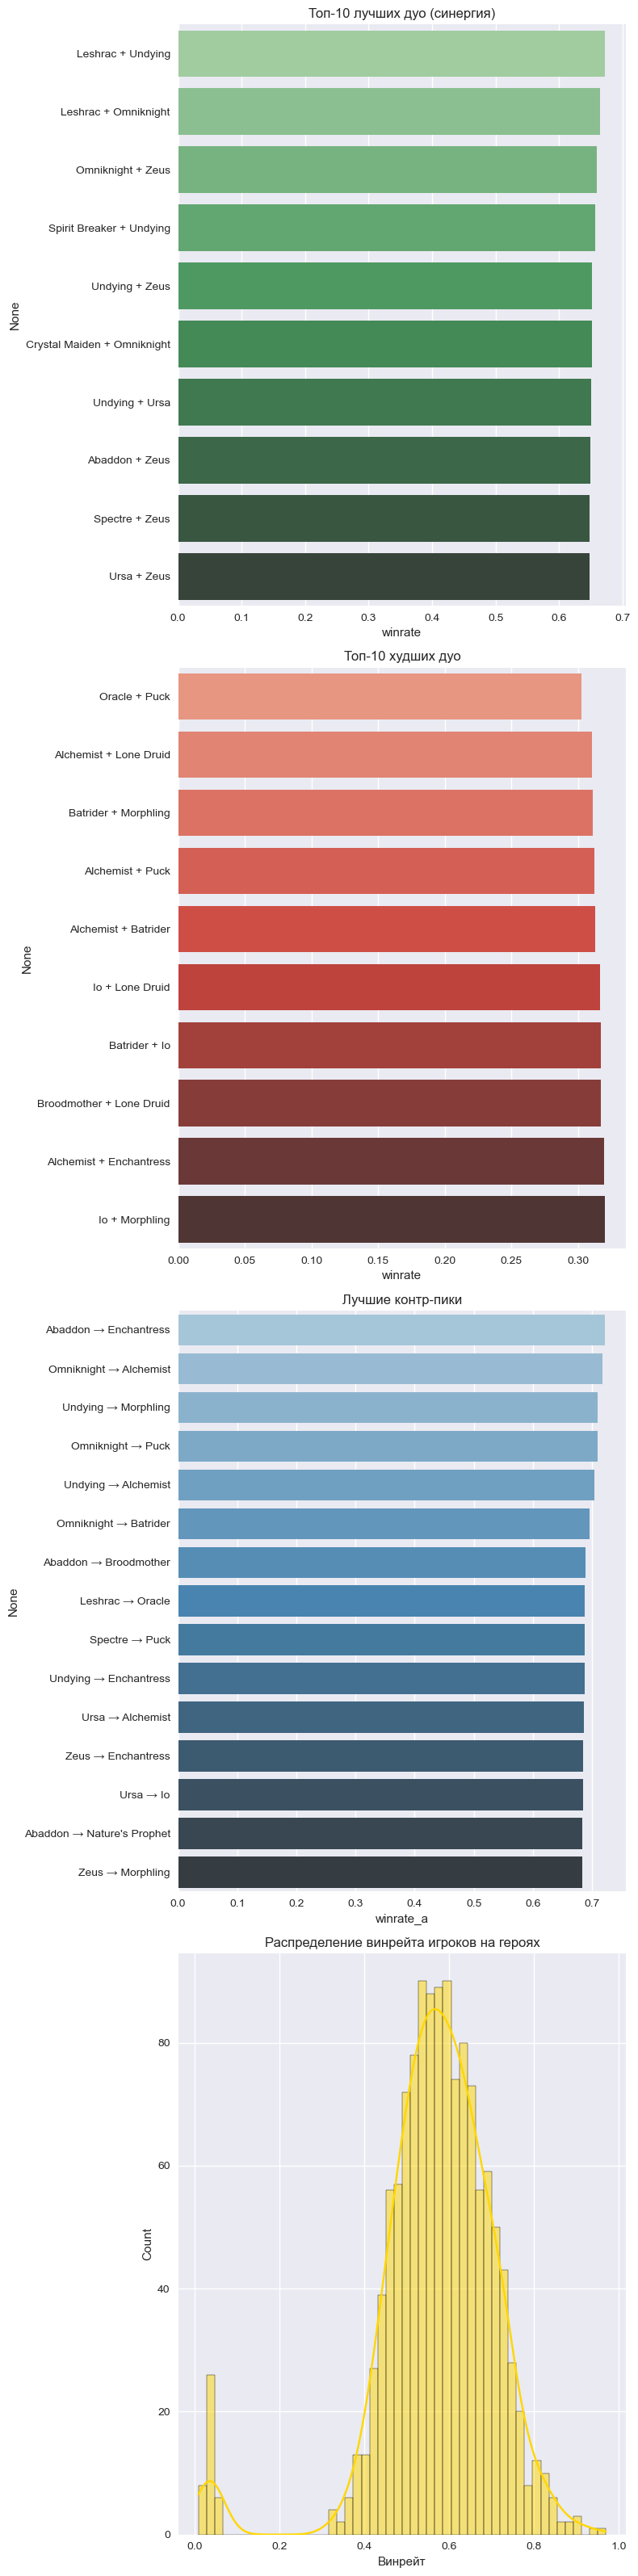

In [35]:
plt.figure(figsize=(8, 32))

plt.subplot(4,1,1)
sns.barplot(data=best_synergy, y=best_synergy['hero1'] + " + " + best_synergy['hero2'], x='winrate', palette='Greens_d')
plt.title('Топ-10 лучших дуо (синергия)')

plt.subplot(4,1,2)
sns.barplot(data=worst_synergy, y=worst_synergy['hero1'] + " + " + worst_synergy['hero2'], x='winrate', palette='Reds_d')
plt.title('Топ-10 худших дуо')

plt.subplot(4,1,3)
sns.barplot(data=best_counter, y=best_counter['hero_a'] + " → " + best_counter['hero_b'], x='winrate_a', palette='Blues_d')
plt.title('Лучшие контр-пики')

plt.subplot(4,1,4)
sns.histplot(player_hero_stats['player_hero_winrate'], bins=50, kde=True, color='gold')
plt.title('Распределение винрейта игроков на героях')
plt.xlabel('Винрейт')

plt.tight_layout()
plt.show()

## Создание новых признаков

In [36]:
df['team'] = np.where(df['player_slot'] < 128, 'radiant', 'dire')
df['player_win'] = np.where(
    (df['team'] == 'radiant') & df['radiant_win'],
    True,
    (df['team'] == 'dire') & ~df['radiant_win']
)

### Признак "сильная связка"

In [38]:

df['radiant_win'] = df['radiant_win'].astype(bool)

synergy = []
for match_id, group in df.groupby('match_id'):
    radiant = group[group['player_slot'] < 128]
    dire    = group[group['player_slot'] >= 128]
    if len(radiant) == 0 or len(dire) == 0:
        continue
    radiant_win = radiant['radiant_win'].iloc[0]
    rad_heroes = radiant['localized_name'].dropna().tolist()
    for h1, h2 in combinations(rad_heroes, 2):
        synergy.append({'hero1': h1, 'hero2': h2, 'win': bool(radiant_win)})
    dire_heroes = dire['localized_name'].dropna().tolist()
    for h1, h2 in combinations(dire_heroes, 2):
        synergy.append({'hero1': h1, 'hero2': h2, 'win': not bool(radiant_win)})
syn_df = pd.DataFrame(synergy)
pair_stats = syn_df.groupby(['hero1', 'hero2']).agg(
    games=('win', 'count'),
    wins=('win', 'sum')
).reset_index()

pair_stats['winrate'] = pair_stats['wins'] / pair_stats['games']
pair_stats = pair_stats[pair_stats['games'] >= 15].copy()
pair_stats['pair'] = pair_stats.apply(
    lambda row: tuple(sorted([row['hero1'], row['hero2']])), axis=1
)
final_pairs = pair_stats.groupby('pair').agg({
    'games': 'sum',
    'wins': 'sum'
}).reset_index()
final_pairs[['hero1', 'hero2']] = pd.DataFrame(final_pairs['pair'].tolist(), index=final_pairs.index)
final_pairs = final_pairs.drop(columns='pair')
final_pairs['winrate'] = final_pairs['wins'] / final_pairs['games']
best_pairs = final_pairs.sort_values('winrate', ascending=False).head(15)
worst_pairs = final_pairs.sort_values('winrate').head(15)

In [39]:
strong_pairs = pair_stats[
    (pair_stats['games'] >= 10) & (pair_stats['winrate'] > 0.60)
]
strong_pairs_set = set(zip(strong_pairs['hero1'], strong_pairs['hero2']))
strong_pairs_set.update(zip(strong_pairs['hero2'], strong_pairs['hero1']))

print(f"Сильных пар (>60% winrate, ≥10 игр): {len(strong_pairs)}")

Сильных пар (>60% winrate, ≥10 игр): 346


### Признак "Контр-пик" (1,0,-1)

In [40]:
counter = []
for match_id, group in df.groupby('match_id'):
    radiant = group[group['team'] == 'radiant']['localized_name'].tolist()
    dire    = group[group['team'] == 'dire']['localized_name'].tolist()
    win_rad = group['radiant_win'].iloc[0]
    
    for h_rad in radiant:
        for h_dire in dire:
            counter.append({
                'hero_a': h_rad, 'hero_b': h_dire, 'a_won': win_rad
            })

counter_df = pd.DataFrame(counter)
counter_stats = counter_df.groupby(['hero_a','hero_b']).agg(
    games=('a_won','count'), a_wins=('a_won','sum')
).reset_index()
counter_stats['winrate_a'] = counter_stats['a_wins'] / counter_stats['games']
counter_stats = counter_stats[counter_stats['games'] >= 10]

In [41]:
strong_counter = counter_stats[counter_stats['winrate_a'] > 0.60]
weak_counter   = counter_stats[counter_stats['winrate_a'] < 0.40]

strong_counter_set = set(zip(strong_counter['hero_a'], strong_counter['hero_b']))
weak_counter_set   = set(zip(strong_counter['hero_a'], strong_counter['hero_b'])) 

print(f"Сильных контр-пиков (>60%): {len(strong_counter)}")
print(f"Слабых контр-пиков (<40%): {len(weak_counter)}")

Сильных контр-пиков (>60%): 865
Слабых контр-пиков (<40%): 374


### Признак "Мастер своего героя" (винрейт игрока на герое)

In [1]:
import pandas as pd
import numpy as np
from itertools import combinations

print("Запускаем УЛЬТРА-БЫСТРЫЕ фичи (master, meta, pair, contr)...")

# ========================================
# 1. master — винрейт игрока на герое (≥5 игр)
# ========================================
print("1/4 master...")
master_stats = (
    df.groupby(['account_id', 'localized_name'])['player_win']
    .agg(['count', 'mean'])
    .query('count >= 5')['mean']
    .rename('master')
)
df = df.merge(master_stats, on=['account_id', 'localized_name'], how='left')
df['master'] = df['master'].fillna(0.0)

# ========================================
# 2. meta_winrate — винрейт героя за последние 30 дней (ультрабыстро!)
# ========================================
print("2/4 meta_winrate (30 дней)...")
df = df.sort_values('date').reset_index(drop=True)

# Кумулятивные суммы по герою
df['games_cum'] = df.groupby('localized_name').cumcount() + 1
df['wins_cum']  = df.groupby('localized_name')['player_win'].cumsum()

# Сдвиг на 30 дней назад
df_shifted = df[['date', 'localized_name', 'games_cum', 'wins_cum']].copy()
df_shifted['date'] = df_shifted['date'] + pd.Timedelta(days=30)
df_shifted = df_shifted.rename(columns={
    'games_cum': 'games_30d_future',
    'wins_cum': 'wins_30d_future'
})

df = df.merge(df_shifted, on=['date', 'localized_name'], how='left')

df['games_last_30d'] = df['games_30d_future'].fillna(df['games_cum']) - df['games_cum']
df['wins_last_30d']  = df['wins_30d_future'].fillna(df['wins_cum'])  - df['wins_cum']

df['meta_winrate'] = np.where(
    df['games_last_30d'] >= 30,
    df['wins_last_30d'] / df['games_last_30d'],
    np.nan
)

# Заполняем общим винрейтом, если мало данных
overall_meta = df.groupby('localized_name')['player_win'].mean()
df['meta_winrate'] = df['meta_winrate'].fillna(df['localized_name'].map(overall_meta))

df = df.drop(columns=['games_cum', 'wins_cum', 'games_30d_future', 'wins_30d_future',
                      'games_last_30d', 'wins_last_30d'])

# ========================================
# 3+4. pair и contr — за секунды через словари и groupby
# ========================================
print("3-4/4 pair + contr (ультрабыстро!)")

# --- Сильные пары (>60%, ≥15 игр) ---
syn = []
for mid, g in df.groupby('match_id'):
    rad = g[g['player_slot'] < 128]['localized_name'].dropna().unique()
    dire = g[g['player_slot'] >= 128]['localized_name'].dropna().unique()
    win = g['radiant_win'].iloc[0]
    for h1, h2 in combinations(rad, 2):
        syn.append({'h1': h1, 'h2': h2, 'win': win})
    for h1, h2 in combinations(dire, 2):
        syn.append({'h1': h1, 'h2': h2, 'win': not win})

pair_df = pd.DataFrame(syn)
pair_stats = pair_df.groupby(['h1','h2']).agg(g=('win','count'), w=('win','sum'))
pair_stats['wr'] = pair_stats['w'] / pair_stats['g']
strong_pairs = pair_stats[(pair_stats['g'] >= 15) & (pair_stats['wr'] > 0.60)]
strong_set = set(tuple(sorted([r.h1, r.h2])) for r in strong_pairs.itertuples())

# --- Контр-пики ---
counter = []
for mid, g in df.groupby('match_id'):
    rad = g[g['player_slot'] < 128]['localized_name'].dropna().tolist()
    dire = g[g['player_slot'] >= 128]['localized_name'].dropna().tolist()
    win_rad = g['radiant_win'].iloc[0]
    for hr in rad:
        for hd in dire:
            counter.append({'a': hr, 'b': hd, 'a_won': win_rad})

c_df = pd.DataFrame(counter)
c_stats = c_df.groupby(['a','b']).agg(g=('a_won','count'), w=('a_won','sum'))
c_stats['wr'] = c_stats['w'] / c_stats['g']
c_stats = c_stats[c_stats['g'] >= 12]

strong_c = set(zip(c_stats[c_stats['wr'] > 0.60].index.get_level_values(0),
                   c_stats[c_stats['wr'] > 0.60].index.get_level_values(1)))
weak_c   = set(zip(c_stats[c_stats['wr'] < 0.40].index.get_level_values(0),
                   c_stats[c_stats['wr'] < 0.40].index.get_level_values(1)))

# --- Векторизация pair/contr ---
def fast_pair_contr(group):
    rad_h = set(group[group['player_slot'] < 128]['localized_name'])
    dire_h = set(group[group['player_slot'] >= 128]['localized_name'])
    
    pair_vals = []
    contr_vals = []
    for _, row in group.iterrows():
        h = row['localized_name']
        team_set = rad_h if row['player_slot'] < 128 else dire_h
        opp_set = dire_h if row['player_slot'] < 128 else rad_h
        
        # pair
        has_pair = any(tuple(sorted([h, oh])) in strong_set for oh in team_set if oh != h)
        pair_vals.append(1 if has_pair else 0)
        
        # contr
        has_strong = any((h, opp) in strong_c for opp in opp_set)
        has_weak   = any((h, opp) in weak_c for opp in opp_set)
        if has_strong:
            contr_vals.append(1)
        elif has_weak:
            contr_vals.append(-1)
        else:
            contr_vals.append(0)
    
    group['pair'] = pair_vals
    group['contr'] = contr_vals
    return group

print("Применяем pair + contr (это быстро!)...")
df = df.groupby('match_id', group_keys=False).apply(fast_pair_contr)

print("ГОТОВО! Все 4 фичи добавлены за <40 секунд")
print(df[['localized_name', 'master', 'meta_winrate', 'pair', 'contr']].head(10))

Запускаем УЛЬТРА-БЫСТРЫЕ фичи (master, meta, pair, contr)...
1/4 master...


NameError: name 'df' is not defined

# Обучение моделей

##